In [1]:
import pandas as pd
import sys
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


In [2]:
# -----------------------------
# 1️⃣ Load or prepare your data
# -----------------------------
# Replace this with your actual data
# Must have columns: "Date" and "Prices"
# Example dummy dataset:
df=pd.read_csv("Nat_Gas.csv",index_col="Dates", parse_dates=True, dayfirst=True)
df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [3]:
# -----------------------------
# 3️⃣ Fit SARIMAX model (seasonality = 12)
# -----------------------------
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model = SARIMAX(df["Prices"],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print("✅ Model fitted successfully.")

✅ Model fitted successfully.


In [4]:
def predict(year, month):
    Y_MAX = 40          # cap y-axis at this value (change as needed)
    CLIP_NEGATIVES = True
    
    target_date = pd.Timestamp(f"{year}-{month:02d}-01") + MonthEnd(0)
    print("Target (month-end):", target_date.date())
    y=df["Prices"]
    # -----------------------------
    # Setup in-sample prediction range
    # -----------------------------
    first_date = y.index.min()
    last_date = y.index.max()
    
    # Get in-sample predictions (pred_mean will cover the training span)
    pred_in = results.get_prediction(start=first_date, end=last_date)
    pred_mean = pred_in.predicted_mean.copy()
    conf_int = pred_in.conf_int().copy()
    
    # Ensure their indices are month-end freq
    # (if they're integer-indexed for some reason, align to df index)
    if not isinstance(pred_mean.index, pd.DatetimeIndex):
        pred_mean.index = y.index
    if not isinstance(conf_int.index, pd.DatetimeIndex):
        conf_int.index = y.index
    
    # Helper to extend forward (forecast)
    def extend_forward(results, current_end, target_end):
        """Return (new_mean, new_ci) covering months after current_end up to target_end (inclusive)."""
        months = (target_end.year - current_end.year) * 12 + (target_end.month - current_end.month)
        if months <= 0:
            return pd.Series(dtype=float), pd.DataFrame()
        fut = results.get_forecast(steps=months)
        fut_mean = fut.predicted_mean.copy()
        fut_ci = fut.conf_int().copy()
        # create future index as month-end starting after current_end
        future_index = pd.date_range(start=current_end + MonthEnd(1), periods=months, freq="M")
        fut_mean.index = future_index
        fut_ci.index = future_index
        return fut_mean, fut_ci
    
    # Helper to backcast via reversed-series modeling
    def backcast_via_reversed(y, order, seasonal_order, first_date, target_date):
        """
        Fit SARIMAX on reversed series values and forecast forward to cover the required months,
        then reverse results and return (back_mean, back_ci) indexed chronologically.
        """
        # number of months we need before first_date to include target_date
        months = (first_date.year - target_date.year) * 12 + (first_date.month - target_date.month)
        if months <= 0:
            return pd.Series(dtype=float), pd.DataFrame()
        # reverse values (chronologically descending)
        rev_vals = y.values[::-1]
        # Fit a new model on reversed values (no index needed; model uses positional time)
        rev_model = SARIMAX(rev_vals, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
        rev_res = rev_model.fit(disp=False)
        # forecast 'months' steps forward in reversed time
        rev_forecast = rev_res.get_forecast(steps=months)
        rev_mean = pd.Series(rev_forecast.predicted_mean)  # numeric index 0..months-1
        rev_ci = pd.DataFrame(rev_forecast.conf_int(), columns=["lower", "upper"])
        # reverse results so they go chronologically from oldest -> newest
        back_mean = rev_mean[::-1].reset_index(drop=True)
        back_ci = rev_ci.iloc[::-1].reset_index(drop=True)
        # assign proper month-end index ending one month before first_date
        back_index = pd.date_range(end=first_date - MonthEnd(1), periods=months, freq="M")
        back_mean.index = back_index
        back_ci.index = back_index
        back_ci.columns = [conf_int.columns[0], conf_int.columns[1]]  # match names
        return back_mean, back_ci
    
    # -----------------------------
    # Extend preds forward if needed (forecast)
    # -----------------------------
    if target_date > last_date:
        fut_mean, fut_ci = extend_forward(results, last_date, target_date)
        if not fut_mean.empty:
            pred_mean = pd.concat([pred_mean, fut_mean])
            conf_int = pd.concat([conf_int, fut_ci])
        # now forecast_value and CI are at target_date
        forecast_value = pred_mean.loc[target_date]
        lower_ci = conf_int.loc[target_date].iloc[0]
        upper_ci = conf_int.loc[target_date].iloc[1]
    
    # -----------------------------
    # Backcast if needed (target before start)
    # -----------------------------
    elif target_date < first_date:
        print("🔁 Target date is before dataset start — performing backcast via reversed-series.")
        # use same orders as your fitted model. We'll try to extract them from results.model
        try:
            order = results.model.order
            seasonal_order = results.model.seasonal_order
        except Exception:
            # fallback to common default
            order = (1,1,1)
            seasonal_order = (1,1,1,12)
    
        back_mean, back_ci = backcast_via_reversed(y, order, seasonal_order, first_date, target_date)
        if not back_mean.empty:
            # prepend backcast to in-sample preds
            pred_mean = pd.concat([back_mean, pred_mean])
            conf_int = pd.concat([back_ci, conf_int])
        forecast_value = pred_mean.loc[target_date]
        lower_ci = conf_int.loc[target_date].iloc[0]
        upper_ci = conf_int.loc[target_date].iloc[1]
    
    # -----------------------------
    # Target within in-sample
    # -----------------------------
    else:
        forecast_value = pred_mean.loc[target_date]
        lower_ci = conf_int.loc[target_date].iloc[0]
        upper_ci = conf_int.loc[target_date].iloc[1]
    
    # -----------------------------
    # Build forecast_df from current pred_mean/conf_int
    # -----------------------------
    forecast_df = pd.DataFrame({
        'Predicted': pred_mean,
        'Lower_CI': conf_int.iloc[:, 0],
        'Upper_CI': conf_int.iloc[:, 1]
    })
    
    # Clip negatives if requested
    if CLIP_NEGATIVES:
        forecast_df["Predicted"] = forecast_df["Predicted"].clip(lower=0)
        forecast_df["Lower_CI"] = forecast_df["Lower_CI"].clip(lower=0)
        forecast_df["Upper_CI"] = forecast_df["Upper_CI"].clip(lower=0)
    
    # -----------------------------
    # Print results
    # -----------------------------
    print(f"\n📊 Prediction for {target_date.date()}: {forecast_value:.2f}")
    print(f"95% confidence interval: [{lower_ci:.2f}, {upper_ci:.2f}]")
    
    # Show nearby predictions (2 months either side)
    nearby = forecast_df[
        (forecast_df.index >= target_date - pd.DateOffset(months=2)) &
        (forecast_df.index <= target_date + pd.DateOffset(months=2))
    ]
    if nearby.empty:
        print("\n⚠️ Target date outside current forecast range (no nearby rows).")
    else:
        print("\n🔍 Nearby Predictions:")
        print(nearby)
    
    # -----------------------------
    # Plot observed + predictions
    # -----------------------------
    plt.figure(figsize=(11,5))
    plt.plot(y, label='Observed', color='black')
    plt.plot(forecast_df["Predicted"], label='Predicted', color='blue')
    plt.fill_between(forecast_df.index,
                     forecast_df["Lower_CI"],
                     forecast_df["Upper_CI"],
                     alpha=0.3)
    plt.axvline(target_date, color='red', linestyle='--', label=f"Target {target_date.date()}")
    plt.title("SARIMAX: Observed + Predicted (forecast & backcast)")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.ylim(0, Y_MAX)
    plt.legend()
    plt.show()
    return(forecast_value)


In [5]:
def date(year,month):
    Y_MAX = 40          # cap y-axis at this value (change as needed)
    CLIP_NEGATIVES = True
    
    target_date = pd.Timestamp(f"{year}-{month:02d}-01") + MonthEnd(0)
    return target_date
    

Enter the injection date year (e.g., 2025):  2005
Enter the injection date month (1–12):  5


Target (month-end): 2005-05-31
🔁 Target date is before dataset start — performing backcast via reversed-series.

📊 Prediction for 2005-05-31: 1.44
95% confidence interval: [0.72, 2.17]

🔍 Nearby Predictions:
            Predicted  Lower_CI  Upper_CI
2005-05-31   1.441275  0.716995  2.165555
2005-06-30   1.288807  0.564713  2.012900
2005-07-31   1.520776  0.796173  2.245378


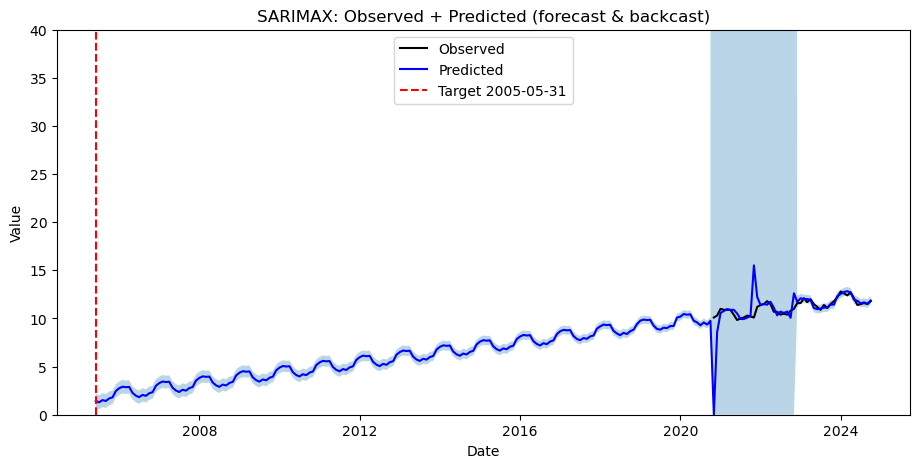

Enter the withdrawal date year (e.g., 2025):  2025
Enter the withdrawal date month (1–12):  12


Target (month-end): 2025-12-31

📊 Prediction for 2025-12-31: 13.53
95% confidence interval: [12.72, 14.35]

🔍 Nearby Predictions:
            Predicted   Lower_CI   Upper_CI
2025-10-31  12.644162  11.886481  13.401842
2025-11-30  13.081393  12.308200  13.854586
2025-12-31  13.534825  12.719249  14.350401


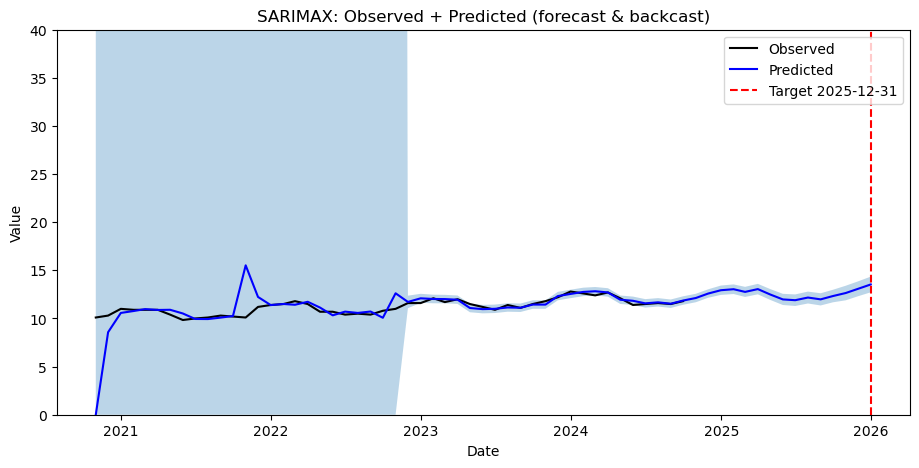

Enter the storage capacity  4
Enter the amount injected  3
Enter the storage cost per day  6
Enter the amount injected  1
Enter the amount present  1
Enter the amount withdrawn  3


Value of contract is 39.16320073413945


In [6]:
year_i = int(input("Enter the injection date year (e.g., 2025): "))
month_i = int(input("Enter the injection date month (1–12): "))
injection_date_val=predict(year_i,month_i)
injection_date=date(year_i,month_i)
year_w = int(input("Enter the withdrawal date year (e.g., 2025): "))
month_w = int(input("Enter the withdrawal date month (1–12): "))
withdrawal_date_val=predict(year_w,month_w)
withdrawal_date=date(year_i,month_i)
c = float(input("Enter the storage capacity "))
inj = float(input("Enter the amount injected "))
if inj>c:
    print("not possible")
    sys.exit(1)
cost=float(input("Enter the storage cost per day "))
if year_i>year_w :
    print("not possible")
    sys.exit(1)
amt_i=float(input("Enter the amount injected "))
amt_p=float(input("Enter the amount present "))
if (amt_i+amt_p)>c :
    print("not possible")
    sys.exit(1)
amt_w=float(input("Enter the amount withdrawn "))
if amt_i>amt_w :
    print("not possible")
    sys.exit(1)
v=float((amt_w*withdrawal_date_val)-(amt_i*injection_date_val)-(cost*(amt_i+amt_p)*(withdrawal_date-injection_date).days))
print(f"Value of contract is {v}")
